In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy.stats as stats
from scipy.stats import friedmanchisquare, wilcoxon
import math
import re
import itertools
import scikit_posthocs as sp

In [3]:
def convert_hup_to_rid(rh_table,hup_id):
    # get number from hup_id
    hup_num = int(hup_id[3:6])
    # get rid from rid_hup_table
    rid = rh_table.loc[rh_table["hupsubjno"] == hup_num]["record_id"].values[0]
    return rid

def padId(id):
    if len(id) == 5:
        id = id[0:3] + "0" + id[-2:]
    return id

In [4]:
parent_directory = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))),'data')
util_directory = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))),'util')
atlas_directory = os.path.join(parent_directory,"atlas")
data_final_directory = os.path.join(parent_directory,"data_final")

assert os.path.isdir(parent_directory), f"{parent_directory} does not exist."

rh_table = pd.read_csv(os.path.join(data_final_directory,'rid_hup_table.csv'))

# read metadata csv
metadata_csv = pd.read_csv("../../data/data_final/combined_atlas_metadata.csv")

# open excel file
df = pd.read_excel(os.path.join(data_final_directory,'neuropsych_data.xlsx'), sheet_name=1)
# print keys of dataframe
#print(df.keys())
# remove first row of dataframe
df = df.iloc[1:]

In [5]:
# read though all patient sleep staging results and extract stages corresponding to pre-ictal hours

all_rids = []
all_stages = []
all_stages_expanded = []
all_ids = []
all_end_times = []
all_end_times_expanded = []

# for each directory in parent_directory that begins with "sub"
for directory in [directory for directory in os.listdir(parent_directory) if directory.startswith("sub-")]:
    # list files in directory
    files = os.listdir(os.path.join(parent_directory,directory))
    # for each file in files that contains "night2" and "preictalhrs_sleepstage"
    for file in [file for file in files if "night2" in file and "preictalhrs_sleepstage" in file]:
        num_preictal_hrs = re.sub('\D', '', file.split("_")[-2])
        #print(f"Patient {file} has {num_preictal_hrs} preictal hours of sleep staging.")
        # open file
        staging = pd.read_csv(os.path.join(parent_directory,directory,file))
        # extract preictal staging where file_index > 1
        preictal_stages = []
        
        print(file)

        for i in range(2, int(num_preictal_hrs)+2):
            print(i)
            print(staging[staging['file_index']==i]['sleep_stage'].values)
            preictal_stages.append(staging[staging['file_index']==i]['sleep_stage'].values)
            
        # get rid
        rid_num = convert_hup_to_rid(rh_table,padId(file.split("_")[0]))
        hup_id = padId(file.split("_")[0])
        # pad to 4 digits
        rid = f"sub-RID{rid_num:04d}"
        #print(f"Patient {file} has {round(len(preictal_stages)/119)} preictal hours of sleep staging (RID = {rid}).")

        all_rids.append(rid)
        all_stages.append(preictal_stages)
        all_stages_expanded.extend(preictal_stages)
        all_ids.append(hup_id)
    # for each file in files that contains "night2" and "preictalhrs_sleepstage"
    matching = [file for file in files if "night2" in file and "preictalhrs_summary" in file]
    if len(matching) == 0:
        #print(f"Patient {directory} has no summary file.")
        continue
    file = matching[0]
    #print(file)
    summary_data = pd.read_csv(os.path.join(parent_directory,directory,file))
    # get unique file names
    unique_files = summary_data['File'].unique()
    # drop empty files
    unique_files = [file for file in unique_files if file != ' ']
    #print(unique_files)
    end_times = []
    for file in unique_files:
        print((int(file.split("_")[-1].split(".")[0]),int(file.split("_")[-2].split(".")[-2])))
        if int(file.split("_")[-1].split(".")[0])-int(file.split("_")[-2].split(".")[-2]) < 4000e6:
            end_times.append(int(file.split("_")[-1].split(".")[0])/1e6)
            print(f"{int(file.split('_')[-1].split('.')[0])/1e6} added ^")
    all_end_times.append(end_times)

print(all_end_times)

# load day night seizure spreadsheet
dn_xls = pd.read_excel(os.path.join(util_directory,'day_night_seizure_data.xlsx'), sheet_name=0)

stages_col = []
#counter = 0
last_pat = None
added_counter = 0

# iterate through rows
for index, row in dn_xls.iterrows():
    if (row['IEEGID'] == 1) and (row['day_night_number']%2 == 0):
        if row['Patient'] != last_pat:
            #if (len(all_stages[pat_ind]) > counter) and last_pat != None:
                #print(f"NUMBER STAGES NOT INCLUDED: {len(all_stages[pat_ind])-counter}")
                #print(f"STAGES NOT INCLUDED: {all_stages[pat_ind][counter:]}")
            counter = 0
        last_pat = row['Patient']
        print(f"Patient {row['Patient']}.")
        # get end times
        if len((np.where(np.array(all_ids) == row['Patient'])[0]).tolist()) > 0:
            pat_ind = np.where(np.array(all_ids) == row['Patient'])[0].tolist()[0]
            print(f"Patient index {pat_ind}.")
            end_times = all_end_times[pat_ind]
        else:
            end_times = []
        # check if this row's seizure start time is in end_times
        #end_times = [round(time) for time in end_times]
        #rounded_start = round(row['start'])
        
        start = row['start']
        print(f"start time: {start}")
        print(f"end_times in summary file {end_times}")
        
        if start in end_times:
            
            print(f"Found at index {end_times.index(start)}.")
            # get index
            time_ind = end_times.index(start)
            stages_col.append(all_stages[pat_ind][counter])
            counter += 1
            added_counter += 1
        else:
            print("Not found.")
            stages_col.append(None)
    else:
        stages_col.append(None)

print(f"{added_counter}/{len(all_stages_expanded)}")
dn_xls['stages'] = stages_col
print(dn_xls)
# save to xlsx
dn_xls.to_excel(os.path.join(data_final_directory,'day_night_seizures_and_stages_data.xlsx'), sheet_name="Sheet1")
print("Done.")

HUP101_phaseII_D01_110679000000.0_153879000000.0_night2_6preictalhrs_sleepstage.csv
2
[2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 2 1 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
3
[1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 2 2 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 2 2
 2 2 1 1 1 1 1 1 2 2 2 1 1 2 2 1 2 1 2 2 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 2 2
 1 1 1 1 1 1 1 1]
4
[1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 1 2 2 2
 2 2 1 1 2 1 2 1 2 2 2 2 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
5
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [6]:
all_ids

['HUP101',
 'HUP192',
 'HUP202',
 'HUP144',
 'HUP139',
 'HUP181',
 'HUP112',
 'HUP068',
 'HUP150',
 'HUP127',
 'HUP065',
 'HUP186',
 'HUP205',
 'HUP106',
 'HUP171',
 'HUP108',
 'HUP078',
 'HUP175',
 'HUP147',
 'HUP218',
 'HUP111',
 'HUP166',
 'HUP188',
 'HUP182',
 'HUP154',
 'HUP159',
 'HUP161',
 'HUP116',
 'HUP082',
 'HUP185',
 'HUP178',
 'HUP196',
 'HUP075',
 'HUP172',
 'HUP105',
 'HUP135',
 'HUP142',
 'HUP204',
 'HUP107',
 'HUP093',
 'HUP126',
 'HUP151',
 'HUP080',
 'HUP187',
 'HUP064',
 'HUP169',
 'HUP087',
 'HUP113',
 'HUP119',
 'HUP180',
 'HUP121',
 'HUP070',
 'HUP199',
 'HUP094',
 'HUP100',
 'HUP177',
 'HUP203',
 'HUP138',
 'HUP145',
 'HUP141',
 'HUP136',
 'HUP173',
 'HUP179',
 'HUP074',
 'HUP207',
 'HUP184',
 'HUP089',
 'HUP083',
 'HUP160',
 'HUP213',
 'HUP167',
 'HUP084',
 'HUP110',
 'HUP189',
 'HUP128',
 'HUP155',
 'HUP174',
 'HUP097',
 'HUP190',
 'HUP073',
 'HUP146']

In [7]:
# load in epilepsy probabilities
epilepsy_probabilities = np.load(os.path.join(data_final_directory,'combined_atlas_epiprobs_bothfts_normative.npz'))

# get values epilepsy probablity values for each patient

epi_prob_W = []
epi_prob_N2 = []
epi_prob_N3 = []
epi_prob_R = []

for rid in all_rids:
    idx = np.where((metadata_csv['pt'] == rid) & (((metadata_csv['ch1_soz'] == True) | (metadata_csv['ch2_soz'] == True)) | (metadata_csv['normative'] == False)))
    print(f"rid: {rid}")
    print(f"idx: {idx}")
    # get epilepsy probabilities for that patient
    epi_prob_W.append(epilepsy_probabilities['W'][idx].tolist())
    epi_prob_N2.append(epilepsy_probabilities['N2'][idx].tolist())
    epi_prob_N3.append(epilepsy_probabilities['N3'][idx].tolist())
    epi_prob_R.append(epilepsy_probabilities['R'][idx].tolist())

# print lengths of epilepsy probabilities
print(f"all_rids: {len(all_rids)}")
print(f"epi_prob_W: {len(epi_prob_W)}")
print(f"epi_prob_N2: {len(epi_prob_N2)}")
print(f"epi_prob_N3: {len(epi_prob_N3)}")
print(f"epi_prob_R: {len(epi_prob_R)}")

rid: sub-RID0102
idx: (array([3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540,
       3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551,
       3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562,
       3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573,
       3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584,
       3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595,
       3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604]),)
rid: sub-RID0530
idx: (array([7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946,
       7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957,
       7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968,
       7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979,
       7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990,
       7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001,
       8002, 8

In [8]:
num_to_stage_dict = {1:'R',2:'W',3:'N1',4:'N2',5:'N3'}

all_stage_modes = []
all_stages_valid = []

all_nemenyi_res = []
all_median_diffs = []

for k in range(len(all_rids)):
    # print percentage of each number in all_stages
    print(f"RID {all_rids[k]}")
    #print(all_stages[k])
    # get mode
    this_pt_modes = []
    for arr in all_stages[k]:
        #print(f"arr: {arr}")
        this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
    print(this_pt_modes)
    all_stage_modes.append(this_pt_modes)

    if epi_prob_W[k] == []:
        print(f"RID {all_rids[k]} has no epilepsy probabilities.")
        continue

    # # plot histogram of all epilepsy probablities
    # bins=np.arange(0,1.1,0.05)
    # # 4 by 1 subplots
    # fig, ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(20,5))
    # # histogram
    # ax[0].hist(np.concatenate(epi_prob_W[k]),bins=bins)
    # ax[0].set_title('W')
    # ax[0].set_ylabel('Count')
    # ax[0].set_xlabel('Epilepsy Probability')
    # ax[0].axvline(np.mean(np.concatenate(epi_prob_W[k])),color='red',linestyle='--')
    # ax[1].hist(np.concatenate(epi_prob_N2[k]),bins=bins)
    # ax[1].set_title('N2')
    # ax[1].set_ylabel('Count')
    # ax[1].set_xlabel('Epilepsy Probability')
    # ax[1].axvline(np.mean(np.concatenate(epi_prob_N2[k])),color='red',linestyle='--')
    # ax[2].hist(np.concatenate(epi_prob_N3[k]),bins=bins)
    # ax[2].set_title('N3')
    # ax[2].set_ylabel('Count')
    # ax[2].set_xlabel('Epilepsy Probability')
    # ax[2].axvline(np.mean(np.concatenate(epi_prob_N3[k])),color='red',linestyle='--')
    # ax[3].hist(np.concatenate(epi_prob_R[k]),bins=bins)
    # ax[3].set_title('R')
    # ax[3].set_ylabel('Count')
    # ax[3].set_xlabel('Epilepsy Probability')
    # ax[3].axvline(np.mean(np.concatenate(epi_prob_R[k])),color='red',linestyle='--')

    # plt.suptitle(f"{all_rids[k]}: {this_pt_modes}")
    # plt.show()

    # Friedman Chi Squared test
    stat, p_value = friedmanchisquare(np.concatenate(epi_prob_W[k]),np.concatenate(epi_prob_N2[k]),np.concatenate(epi_prob_N3[k]),np.concatenate(epi_prob_R[k]))
    
    if p_value < 0.05:
        f_res = pd.DataFrame({'test':'Friedman','statistic':stat,'pvalue':p_value},index=[0])

        df_dist = pd.DataFrame(np.vstack([np.concatenate(epi_prob_W[k]),np.concatenate(epi_prob_N2[k]),np.concatenate(epi_prob_N3[k]),np.concatenate(epi_prob_R[k])]).T,columns=['W','N2','N3','R'])

        median_diffs = [np.median(df_dist[i])-np.median(df_dist[j]) for i,j in itertools.combinations(df_dist.columns,2)]

        print([x for x in itertools.combinations(df_dist.columns,2)])
        print(f"Median differences: {median_diffs}")

        try:
            wilc_test = [wilcoxon(df_dist[i],df_dist[j]) for i,j in itertools.combinations(df_dist.columns,2)]
            w_res = pd.DataFrame(wilc_test)
        
            w_res['test'] = [f'wilcoxon {i} vs {j}' for i,j in itertools.combinations(df_dist.columns,2)]

            all_res = pd.concat([f_res,w_res])
            all_res['significant'] = all_res['pvalue'] < 0.05
            print(all_res)
        except ValueError:
            print("ValueError encountered, skipping.")
            
        print("\nResults of Nemenyi post-hoc test:")
        data = np.array([np.concatenate(epi_prob_W[k]),np.concatenate(epi_prob_N2[k]),np.concatenate(epi_prob_N3[k]),np.concatenate(epi_prob_R[k])])
        nemenyi_res = sp.posthoc_nemenyi_friedman(data.T)
        # rename columns and rows
        nemenyi_res.columns = ['W','N2','N3','R']
        nemenyi_res.index = ['W','N2','N3','R']
        print(nemenyi_res)
        all_nemenyi_res.append(nemenyi_res)
        all_stages_valid.append(all_stages[k])
        all_median_diffs.append(median_diffs)
    
    else:
        print(f"statistic: {stat}")
        print(f"p-value: {p_value}")
        print("No significant difference between epilepsy probabilities across stages.")

    print("\n=========================\n")
        

RID sub-RID0102
['R', 'R', 'R', 'R', 'R', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.0012942038018999846, -0.03836737005789062, 0.02386396588968298, -0.037073166255990636, 0.025158169691582966, 0.0622313359475736]
                test  statistic        pvalue  significant
0           Friedman     28.712  2.574216e-06         True
0   wilcoxon W vs N2   1189.000  2.126868e-01        False
1   wilcoxon W vs N3    483.000  6.548907e-07         True
2    wilcoxon W vs R   1335.000  6.346087e-01        False
3  wilcoxon N2 vs N3    863.000  3.000634e-03         True
4   wilcoxon N2 vs R   1140.000  1.323347e-01        False
5   wilcoxon N3 vs R    841.000  2.043439e-03         True

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.752650  0.001000  0.610652
N2  0.752650  1.000000  0.015645  0.137297
N3  0.001000  0.015645  1.000000  0.001000
R   0.610652  0.137297  0.001000  1.000000


RID sub-RID0530
['R', 'R', 'W', 'W', 'W', 'W', 'W', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.0647098973186293, 0.04171126014375032, 0.08944691306988153, -0.02299863717487899, 0.024737015751252228, 0.04773565292613122]
                test    statistic    pvalue  significant
0           Friedman     8.272727  0.040699         True
0   wilcoxon W vs N2   732.000000  0.017035         True
1   wilcoxon W vs N3  1022.000000  0.593753        False
2    wilcoxon W vs R   978.000000  0.415370        False
3  wilcoxon N2 vs N3   771.000000  0.032613         True
4   wilcoxon N2 vs R   999.000000  0.496295        False
5   wilcoxon N3 vs R   987.000000  0.449057        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.134312  0.900000  0.228754
N2  0.134312  1.000000  0.177078  0.900000
N3  0.900000  0.177078  1.000000  0.289265
R   0.228754  0.900000  0.289265  1.000000


RID sub-RID0646
['R']
statistic: 3.436657681940793
p-value: 0.3290708056997579
No significant difference between epilepsy probabilities across stages.


RID sub-RID0112
['W', 'N2', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.022319259623210574, 0.02486131283997059, 0.06386076840227393, 0.047180572463181164, 0.08618002802548451, 0.038999455562303345]
                test   statistic    pvalue  significant
0           Friedman    8.531915  0.036207         True
0   wilcoxon W vs N2  142.000000  0.258824        False
1   wilcoxon W vs N3  116.000000  0.079461        False
2    wilcoxon W vs R  158.000000  0.198241        False
3  wilcoxon N2 vs N3  130.000000  0.156344        False
4   wilcoxon N2 vs R  164.0000

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           W        N2        N3         R
W   1.000000  0.900000  0.338619  0.066533
N2  0.900000  1.000000  0.567321  0.164526
N3  0.338619  0.567321  1.000000  0.843408
R   0.066533  0.164526  0.843408  1.000000


RID sub-RID0307
['W', 'W']
statistic: 7.2222222222222285
p-value: 0.06514216730615258
No significant difference between epilepsy probabilities across stages.


RID sub-RID0490
['W', 'N3']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.0802720263599492, -0.03662577716526216, -0.0321619094004435, 0.04364624919468704, 0.048110116959505705, 0.004463867764818663]
                test   statistic    pvalue  significant
0           Friedman   16.393548  0.000942         True
0   wilcoxon W vs N2  462.000000  0.000310         True
1   wilcoxon W vs N3  747.000000  0.107607        False
2    wilcoxon W vs R  834.000000  0.317757        False
3  wilcoxon N2 vs N3  653.000000  0.023324         True
4   wilcoxon N2 vs R  842.0000

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.001298  0.099001  0.894702
N2  0.001298  1.000000  0.504255  0.014768
N3  0.099001  0.504255  1.000000  0.379607
R   0.894702  0.014768  0.379607  1.000000


RID sub-RID0042
['N3', 'W', 'N2', 'N2', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.06683810671867768, 0.07611463956028464, 0.12567890847903662, 0.009276532841606955, 0.058840801760358954, 0.049564268918752]
                test  statistic    pvalue  significant
0           Friedman       9.72  0.021103         True
0   wilcoxon W vs N2      25.00  0.047913         True
1   wilcoxon W vs N3      27.00  0.063721        False
2    wilcoxon W vs R      13.00  0.005371         True
3  wilcoxon N2 vs N3      55.00  0.803955        False
4   wilcoxon N2 vs R      44.00  0.389404        False
5   wilcoxon N3 vs R      39.00  0.252380        False

Results of Nemenyi post-hoc test:
           W        N2        N3    

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

        W        N2        N3         R
W   1.000  0.001000  0.001000  0.001000
N2  0.001  1.000000  0.324495  0.289867
N3  0.001  0.324495  1.000000  0.002982
R   0.001  0.289867  0.002982  1.000000


RID sub-RID0322
['W', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.022187828088209155, -0.0003069197772889859, 0.0405514697960013, 0.02188090831092017, 0.06273929788421045, 0.040858389573290285]
                test   statistic        pvalue  significant
0           Friedman   31.523077  6.595982e-07         True
0   wilcoxon W vs N2  100.000000  1.594152e-05         True
1   wilcoxon W vs N3  202.000000  7.834594e-03         True
2    wilcoxon W vs R  299.000000  2.091193e-01        False
3  wilcoxon N2 vs N3  246.000000  4.435780e-02         True
4   wilcoxon N2 vs R  127.000000  1.200968e-04         True
5   wilcoxon N3 vs R  193.000000  5.187312e-03         True

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.001837  0.053506  0.497308
N2  0.001837  1.000000  0.694396  0.001000
N3  0.053506  0.694396  1.000000  0.001000
R   0.497308  0.001000  0.001000  1.000000


RID sub-RID0186
['W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.058294200317675654, -0.019379534028792805, 0.022964904245495493, -0.07767373434646846, -0.03532929607218016, 0.0423444382742883]
                test   statistic        pvalue  significant
0           Friedman   26.640845  7.001607e-06         True
0   wilcoxon W vs N2  300.000000  8.219179e-05         True
1   wilcoxon W vs N3  585.000000  1.211340e-01        False
2    wilcoxon W vs R  755.000000  4.365065e-01        False
3  wilcoxon N2 vs N3  186.000000  9.927399e-07         True
4   wilcoxon N2 vs R  590.000000  3.982173e-02         True
5   wilcoxon N3 vs R  832.000000  8.556257e-01        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.001000  0.841096  0.476177
N2  0.001000  1.000000  0.001000  0.057325
N3  0.841096  0.001000  1.000000  0.115424
R   0.476177  0.057325  0.115424  1.000000


RID sub-RID0055
['N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.03132107927605332, 0.21205879627459634, -0.09271908404211693, 0.24337987555064966, -0.06139800476606361, -0.30477788031671327]
                test   statistic        pvalue  significant
0           Friedman   38.639098  2.069726e-08         True
0   wilcoxon W vs N2  235.000000  8.091656e-01        False
1   wilcoxon W vs N3    0.000000  9.313226e-10         True
2    wilcoxon W vs R  211.000000  4.797734e-01        False
3  wilcoxon N2 vs N3    0.000000  8.857458e-05         True
4   wilcoxon N2 vs R   72.000000  2.179573e-01        False
5   wilcoxon N3 vs R    0.000000  8.857458e-05         True

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


        W        N2     N3         R
W   1.000  0.900000  0.001  0.900000
N2  0.900  1.000000  0.001  0.843408
N3  0.001  0.001000  1.000  0.001000
R   0.900  0.843408  0.001  1.000000


RID sub-RID0420
['N2', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.08679096264461572, -0.08006140051381927, -0.05670311210511994, 0.0067295621307964515, 0.03008785053949578, 0.02335828840869933]
                test    statistic    pvalue  significant
0           Friedman    21.162162  0.000097         True
0   wilcoxon W vs N2   941.000000  0.016155         True
1   wilcoxon W vs N3   506.000000  0.000002         True
2    wilcoxon W vs R   785.000000  0.001171         True
3  wilcoxon N2 vs N3  1242.000000  0.433132        False
4   wilcoxon N2 vs R  1255.000000  0.475345        False
5   wilcoxon N3 vs R  1183.000000  0.270597        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.012021  0.001000  0.006404
N2  0.012021  1.000000  0.534630  0.900000
N3  0.001000  0.534630  1.000000  0.641851
R   0.006404  0.900000  0.641851  1.000000


RID sub-RID0588
['W']
statistic: 2.977722772277204
p-value: 0.39507265492016586
No significant difference between epilepsy probabilities across stages.


RID sub-RID0143
['N3', 'W', 'N3']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.14500770467334373, -0.016221879476793155, 0.14500770467334373, -0.16122958415013688, 0.0, 0.16122958415013688]
ValueError encountered, skipping.

Results of Nemenyi post-hoc test:
           W     N2        N3      R
W   1.000000  0.001  0.714253  0.001
N2  0.001000  1.000  0.001000  0.900
N3  0.714253  0.001  1.000000  0.001
R   0.001000  0.900  0.001000  1.000


RID sub-RID0371
['N1', 'N3']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.

                test  statistic        pvalue  significant
0           Friedman  182.92268  2.061928e-39         True
0   wilcoxon W vs N2  110.00000  1.041062e-12         True
1   wilcoxon W vs N3  102.00000  7.789324e-13         True
2    wilcoxon W vs R    0.00000  1.681239e-14         True
3  wilcoxon N2 vs N3  933.00000  3.895033e-03         True
4   wilcoxon N2 vs R    0.00000  2.462831e-14         True
5   wilcoxon N3 vs R    0.00000  2.462831e-14         True

Results of Nemenyi post-hoc test:
        W        N2        N3      R
W   1.000  0.001000  0.001000  0.001
N2  0.001  1.000000  0.131306  0.001
N3  0.001  0.131306  1.000000  0.001
R   0.001  0.001000  0.001000  1.000


RID sub-RID0452
['W', 'N3', 'W', 'N3', 'N2', 'N2']
RID sub-RID0452 has no epilepsy probabilities.
RID sub-RID0334
['N2', 'W', 'W', 'N1']
RID sub-RID0334 has no epilepsy probabilities.
RID sub-RID0677
['W', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differenc

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

        W        N2        N3         R
W   1.000  0.001000  0.001000  0.001000
N2  0.001  1.000000  0.187051  0.900000
N3  0.001  0.187051  1.000000  0.080339
R   0.001  0.900000  0.080339  1.000000


RID sub-RID0230
['W']
statistic: 5.8686868686869
p-value: 0.11817663147957913
No significant difference between epilepsy probabilities across stages.


RID sub-RID0472
['N2', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.5791980670893528, 0.4717221646070014, 0.6525267920365858, -0.10747590248235145, 0.073328724947233, 0.18080462742958445]
                test    statistic        pvalue  significant
0           Friedman   153.613636  4.377012e-33         True
0   wilcoxon W vs N2    94.000000  8.776413e-15         True
1   wilcoxon W vs N3    61.000000  2.946693e-15         True
2    wilcoxon W vs R    20.000000  7.399612e-16         True
3  wilcoxon N2 vs N3  1636.000000  1.803118e-01        False
4   wilcoxon N2 vs R   823.000

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


        W        N2       N3         R
W   1.000  0.001000  0.00100  0.001000
N2  0.001  1.000000  0.53137  0.001342
N3  0.001  0.531370  1.00000  0.001000
R   0.001  0.001342  0.00100  1.000000


RID sub-RID0502
['W', 'R']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.13625293337198324, -0.05712867587566278, -0.07655574465101411, 0.07912425749632046, 0.05969718872096913, -0.01942706877535133]
                test    statistic        pvalue  significant
0           Friedman    39.505102  1.356582e-08         True
0   wilcoxon W vs N2   167.000000  1.948259e-11         True
1   wilcoxon W vs N3   803.000000  6.330301e-04         True
2    wilcoxon W vs R   712.000000  1.330494e-05         True
3  wilcoxon N2 vs N3   592.000000  6.498851e-06         True
4   wilcoxon N2 vs R  1575.000000  8.291180e-01        False
5   wilcoxon N3 vs R  1011.000000  3.489783e-03         True

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.001000  0.058299  0.001721
N2  0.001000  1.000000  0.001721  0.058299
N3  0.058299  0.001721  1.000000  0.666442
R   0.001721  0.058299  0.666442  1.000000


RID sub-RID0146
['W', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.2490406851641468, -0.3306795600388604, -0.32, -0.08163887487471361, -0.07095931483585322, 0.010679560038860392]
                test    statistic        pvalue  significant
0           Friedman   165.882759  9.850361e-36         True
0   wilcoxon W vs N2     0.000000  5.460181e-16         True
1   wilcoxon W vs N3     0.000000  5.460181e-16         True
2    wilcoxon W vs R     0.000000  5.449607e-16         True
3  wilcoxon N2 vs N3   828.000000  4.299046e-06         True
4   wilcoxon N2 vs R  1291.000000  8.369742e-03         True
5   wilcoxon N3 vs R  1888.000000  9.123760e-01        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


        W        N2        N3         R
W   1.000  0.001000  0.001000  0.001000
N2  0.001  1.000000  0.017507  0.130695
N3  0.001  0.017507  1.000000  0.856660
R   0.001  0.130695  0.856660  1.000000


RID sub-RID0329
['W', 'N2', 'N2', 'N2', 'W', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.15615513918438964, -0.295039353808084, -0.10124538145703357, -0.13888421462369438, 0.05490975772735607, 0.19379397235105045]
                test   statistic    pvalue  significant
0           Friedman   24.960674  0.000016         True
0   wilcoxon W vs N2  103.000000  0.000077         True
1   wilcoxon W vs N3   99.000000  0.000056         True
2    wilcoxon W vs R  158.000000  0.002833         True
3  wilcoxon N2 vs N3  165.000000  0.023495         True
4   wilcoxon N2 vs R  276.000000  0.713190        False
5   wilcoxon N3 vs R  177.000000  0.103778        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           W        N2        N3         R
W   1.000000  0.020662  0.001000  0.004789
N2  0.020662  1.000000  0.231998  0.900000
N3  0.001000  0.231998  1.000000  0.474770
R   0.004789  0.900000  0.474770  1.000000


RID sub-RID0338
['N2']
statistic: 7.653465346534775
p-value: 0.053743655803855886
No significant difference between epilepsy probabilities across stages.


RID sub-RID0175
['N3', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.03874645902703244, 0.035501883957603536, 0.07408295372648355, -0.0032445750694289066, 0.035336494699451104, 0.03858106976888001]
                test  statistic    pvalue  significant
0           Friedman        9.0  0.029291         True
0   wilcoxon W vs N2       24.0  0.769531        False
1   wilcoxon W vs N3       27.0  1.000000        False
2    wilcoxon W vs R        8.0  0.048828         True
3  wilcoxon N2 vs N3       15.0  0.674424        False
4   wilcoxon N2 vs R        4.0  0.049

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too

           W        N2       N3         R
W   1.000000  0.900000  0.90000  0.160247
N2  0.900000  1.000000  0.90000  0.109694
N3  0.900000  0.900000  1.00000  0.046280
R   0.160247  0.109694  0.04628  1.000000


RID sub-RID0013
['N2', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.1541070441047458, 0.11002101492944641, 0.19325810358851253, -0.044086029175299385, 0.03915105948376675, 0.08323708865906614]
                test  statistic        pvalue  significant
0           Friedman       39.3  1.499362e-08         True
0   wilcoxon W vs N2      110.0  8.127074e-08         True
1   wilcoxon W vs N3      149.0  1.424360e-06         True
2    wilcoxon W vs R      276.0  1.051987e-03         True
3  wilcoxon N2 vs N3      569.0  8.508778e-01        False
4   wilcoxon N2 vs R      456.0  1.790531e-01        False
5   wilcoxon N3 vs R      441.0  1.338691e-01        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


        W        N2        N3         R
W   1.000  0.001000  0.001000  0.001000
N2  0.001  1.000000  0.900000  0.303466
N3  0.001  0.900000  1.000000  0.303466
R   0.001  0.303466  0.303466  1.000000


RID sub-RID0332
['N2', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.0375344395891794, 0.19422597393567648, 0.19422597393567648, 0.23176041352485588, 0.23176041352485588, 0.0]
ValueError encountered, skipping.

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2     N3      R
W   1.000000  0.517737  0.001  0.001
N2  0.517737  1.000000  0.001  0.001
N3  0.001000  0.001000  1.000  0.900
R   0.001000  0.001000  0.900  1.000


RID sub-RID0356
['W', 'N2', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.0912745195423536, -0.16179049871580298, -0.25241713455338566, -0.07051597917344937, -0.16114261501103205, -0.09062663583758268]
                test    statistic        pvalue  significant
0           Friedman    47.338177  2.945039e-10         True
0   wilcoxon W vs N2   808.000000  6.959594e-04         True
1   wilcoxon W vs N3   477.000000  3.310225e-07         True
2    wilcoxon W vs R   540.000000  1.764353e-06         True
3  wilcoxon N2 vs N3   787.000000  1.949151e-03         True
4   wilcoxon N2 vs R   693.000000  6.703775e-05         True
5   wilcoxon N3 vs R  1012.000000  1.954415e-02         True

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2       N3         R
W   1.000000  0.010109  0.00100  0.001000
N2  0.010109  1.000000  0.26297  0.003454
N3  0.001000  0.262970  1.00000  0.378320
R   0.001000  0.003454  0.37832  1.000000


RID sub-RID0529
['W', 'N2', 'N2', 'W', 'R', 'N2', 'W', 'N2', 'N2', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.021605206765413942, -0.13192550515361368, 0.07314974934003377, -0.11032029838819973, 0.09475495610544771, 0.20507525449364744]
                test  statistic        pvalue  significant
0           Friedman    65.1375  4.687566e-14         True
0   wilcoxon W vs N2    47.0000  4.956475e-05         True
1   wilcoxon W vs N3    38.0000  2.379238e-05         True
2    wilcoxon W vs R    23.0000  6.589234e-06         True
3  wilcoxon N2 vs N3    59.0000  1.264445e-04         True
4   wilcoxon N2 vs R     1.0000  8.751280e-07         True
5   wilcoxon N3 vs R     1.0000  8.751280e-07         True

Results of N

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           W        N2        N3         R
W   1.000000  0.109001  0.001423  0.001423
N2  0.109001  1.000000  0.493877  0.001000
N3  0.001423  0.493877  1.000000  0.001000
R   0.001423  0.001000  0.001000  1.000000


RID sub-RID0065
['W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.047621406020982304, 0.06584553212517194, 0.06095561425316695, 0.018224126104189636, 0.013334208232184647, -0.00488991787200499]
                test    statistic        pvalue  significant
0           Friedman    36.163866  6.914174e-08         True
0   wilcoxon W vs N2  1090.000000  6.067117e-06         True
1   wilcoxon W vs N3   951.000000  4.854248e-07         True
2    wilcoxon W vs R  1066.000000  3.993118e-06         True
3  wilcoxon N2 vs N3  1676.000000  3.585879e-02         True
4   wilcoxon N2 vs R  1574.000000  1.302224e-02         True
5   wilcoxon N3 vs R  1718.000000  5.236197e-02        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.042762  0.001000  0.001000
N2  0.042762  1.000000  0.204735  0.019135
N3  0.001000  0.204735  1.000000  0.751729
R   0.001000  0.019135  0.751729  1.000000


RID sub-RID0440
['R']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.040158648427685156, -0.04473357509209247, 0.031367981114174215, -0.08489222351977763, -0.008790667313510941, 0.07610155620626669]
                test  statistic    pvalue  significant
0           Friedman      16.65  0.000834         True
0   wilcoxon W vs N2       0.00  0.007812         True
1   wilcoxon W vs N3       1.00  0.015625         True
2    wilcoxon W vs R       2.00  0.023438         True
3  wilcoxon N2 vs N3       0.00  0.007812         True
4   wilcoxon N2 vs R      13.00  0.546875        False
5   wilcoxon N3 vs R       1.00  0.015625         True

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.00000

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.07699231742887004, -0.0009898727109879796, 0.08080803383415695, 0.07600244471788206, 0.157800351263027, 0.08179790654514493]
                test   statistic        pvalue  significant
0           Friedman   32.213115  4.719230e-07         True
0   wilcoxon W vs N2  207.000000  4.775609e-02         True
1   wilcoxon W vs N3  247.000000  1.766604e-01        False
2    wilcoxon W vs R  152.000000  2.025827e-03         True
3  wilcoxon N2 vs N3  331.000000  9.749337e-01        False
4   wilcoxon N2 vs R  114.000000  1.753965e-04         True
5   wilcoxon N3 vs R  100.000000  6.035679e-05         True

Results of Nemenyi post-hoc test:


/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           W        N2        N3         R
W   1.000000  0.628096  0.318025  0.003485
N2  0.628096  1.000000  0.900000  0.001000
N3  0.318025  0.900000  1.000000  0.001000
R   0.003485  0.001000  0.001000  1.000000


RID sub-RID0295
['W', 'N2']
statistic: 3.7741935483871316
p-value: 0.2869021572829139
No significant difference between epilepsy probabilities across stages.


RID sub-RID0596
['W', 'W', 'W', 'W', 'W', 'W', 'W', 'N2', 'N1']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.12205198130172253, 0.12205198130172253, 0.12205198130172253, 0.0, 0.0, 0.0]
                test   statistic        pvalue  significant
0           Friedman  151.064516  1.552835e-32         True
0   wilcoxon W vs N2    0.000000  5.145276e-10         True
1   wilcoxon W vs N3    0.000000  5.145276e-10         True
2    wilcoxon W vs R    0.000000  5.145276e-10         True
3  wilcoxon N2 vs N3    0.000000  3.173105e-01        False
4   wilcoxon N2 vs R 

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value o

           W        N2        N3         R
W   1.000000  0.036555  0.900000  0.553301
N2  0.036555  1.000000  0.081535  0.510251
N3  0.900000  0.081535  1.000000  0.725500
R   0.553301  0.510251  0.725500  1.000000


RID sub-RID0050
['R', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.05198503981449784, 0.0019396057349754386, 0.007440120675409931, 0.05392464554947328, 0.05942516048990777, 0.005500514940434492]
                test    statistic        pvalue  significant
0           Friedman    53.293706  1.587186e-11         True
0   wilcoxon W vs N2   503.000000  1.081444e-08         True
1   wilcoxon W vs N3  1356.000000  5.571677e-02        False
2    wilcoxon W vs R  1591.000000  1.716059e-01        False
3  wilcoxon N2 vs N3   268.000000  1.328661e-11         True
4   wilcoxon N2 vs R  1703.000000  3.718389e-01        False
5   wilcoxon N3 vs R  1698.000000  3.606138e-01        False

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W     N2     N3         R
W   1.000000  0.001  0.900  0.604608
N2  0.001000  1.000  0.001  0.001000
N3  0.900000  0.001  1.000  0.900000
R   0.604608  0.001  0.900  1.000000


RID sub-RID0089
['W', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.031895467129279875, 0.011883373291334515, -0.08451678238630811, 0.04377884042061439, -0.052621315257028234, -0.09640015567764262]


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


                test    statistic        pvalue  significant
0           Friedman    42.225152  3.594122e-09         True
0   wilcoxon W vs N2  1125.000000  8.934290e-07         True
1   wilcoxon W vs N3  2566.000000  9.743265e-01        False
2    wilcoxon W vs R  1202.000000  3.272688e-06         True
3  wilcoxon N2 vs N3   853.000000  1.178346e-07         True
4   wilcoxon N2 vs R  1674.000000  2.448790e-02         True
5   wilcoxon N3 vs R  1009.000000  2.384400e-06         True

Results of Nemenyi post-hoc test:
        W     N2     N3      R
W   1.000  0.001  0.900  0.001
N2  0.001  1.000  0.001  0.900
N3  0.900  0.001  1.000  0.001
R   0.001  0.900  0.001  1.000


RID sub-RID0309
['W', 'W', 'W', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.06839611339518173, 0.09141612313011652, -0.18737106686006133, 0.023020009734934788, -0.25576718025524303, -0.2787871899901778]
                test   statistic        pvalue  signif

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

           W        N2        N3         R
W   1.000000  0.001000  0.001000  0.046904
N2  0.001000  1.000000  0.610652  0.001000
N3  0.001000  0.610652  1.000000  0.001000
R   0.046904  0.001000  0.001000  1.000000


RID sub-RID0070
['W', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.014321360319138027, 0.04700279479560074, 0.14878401065559152, 0.061324155114738765, 0.16310537097472955, 0.10178121585999078]
                test    statistic        pvalue  significant
0           Friedman   150.362205  2.201058e-32         True
0   wilcoxon W vs N2  1394.000000  4.655857e-01        False
1   wilcoxon W vs N3   750.000000  8.240881e-05         True
2    wilcoxon W vs R     0.000000  3.606053e-14         True
3  wilcoxon N2 vs N3   483.000000  1.100527e-06         True
4   wilcoxon N2 vs R     0.000000  7.732733e-14         True
5   wilcoxon N3 vs R     0.000000  7.732733e-14         True

Results of Nemenyi post-hoc test:
    

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


                test    statistic        pvalue  significant
0           Friedman    19.030769  2.694229e-04         True
0   wilcoxon W vs N2   526.000000  4.349848e-07         True
1   wilcoxon W vs N3  1087.000000  2.389762e-02         True
2    wilcoxon W vs R  1183.000000  7.497472e-02        False
3  wilcoxon N2 vs N3   856.000000  6.512385e-04         True
4   wilcoxon N2 vs R   849.000000  5.727725e-04         True
5   wilcoxon N3 vs R  1149.000000  5.118035e-02        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.001000  0.408702  0.623751
N2  0.001000  1.000000  0.038389  0.012705
N3  0.408702  0.038389  1.000000  0.900000
R   0.623751  0.012705  0.900000  1.000000


RID sub-RID0296
['N3', 'N3', 'R', 'R', 'R']


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


statistic: 3.4500000000000455
p-value: 0.32730508699609495
No significant difference between epilepsy probabilities across stages.


RID sub-RID0020
['N3']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.03436571634446976, -0.020705797339605356, -0.005390042621299343, 0.013659919004864407, 0.02897567372317042, 0.015315754718306013]
                test  statistic    pvalue  significant
0           Friedman      9.075  0.028310         True
0   wilcoxon W vs N2    140.000  0.019448         True
1   wilcoxon W vs N3    202.000  0.253948        False
2    wilcoxon W vs R    218.000  0.399959        False
3  wilcoxon N2 vs N3    158.000  0.047541         True
4   wilcoxon N2 vs R    246.000  0.746826        False
5   wilcoxon N3 vs R    255.000  0.875446        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.019259  0.524278  0.850366
N2  0.019259  1.000000  0.409442  0.143488
N3  0.5

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.05713037726811948, 0.0319253633042485, 0.032085970494799776, -0.02520501396387098, -0.025044406773319705, 0.00016060719055127626]
                test  statistic    pvalue  significant
0           Friedman       13.7  0.003343         True
0   wilcoxon W vs N2      859.0  0.000036         True
1   wilcoxon W vs N3     1708.0  0.731295        False
2    wilcoxon W vs R     1757.0  0.900623        False
3  wilcoxon N2 vs N3      896.0  0.000073         True
4   wilcoxon N2 vs R     1323.0  0.039359         True
5   wilcoxon N3 vs R     1634.0  0.500676        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.005592  0.900000  0.547175
N2  0.005592  1.000000  0.010187  0.198591
N3  0.900000  0.010187  1.000000  0.647809
R   0.547175  0.198591  0.647809  1.000000


RID sub-RID0060
['W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), (

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.149869  0.900000  0.900000
N2  0.149869  1.000000  0.351885  0.034656
N3  0.900000  0.351885  1.000000  0.692971
R   0.900000  0.034656  0.692971  1.000000


RID sub-RID0582
['N3', 'N2', 'W', 'R', 'N3', 'N3', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.06065690707149733, 0.008616840508462287, 0.09506384543660297, -0.052040066563035045, 0.03440693836510564, 0.08644700492814068]
                test   statistic        pvalue  significant
0           Friedman   36.287129  6.511412e-08         True
0   wilcoxon W vs N2  829.000000  4.027087e-01        False
1   wilcoxon W vs N3  815.000000  3.485774e-01        False
2    wilcoxon W vs R  385.000000  5.674677e-05         True
3  wilcoxon N2 vs N3  605.000000  2.248362e-02         True
4   wilcoxon N2 vs R  458.000000  7.675127e-04         True
5   wilcoxon N3 vs R  245.000000  8.127779e-07         True

Results of Nemeny

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3         R
W   1.000000  0.455435  0.852151  0.001000
N2  0.455435  1.000000  0.111622  0.005419
N3  0.852151  0.111622  1.000000  0.001000
R   0.001000  0.005419  0.001000  1.000000


RID sub-RID0051
['W', 'W']
statistic: 4.615384615384615
p-value: 0.20222627729854578
No significant difference between epilepsy probabilities across stages.


RID sub-RID0106
['W', 'W', 'W', 'W']


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.4093615391795667, -0.4458111634930548, 0.08856745683445105, -0.03644962431348808, 0.49792899601401774, 0.5343786203275058]
                test    statistic        pvalue  significant
0           Friedman   162.240793  6.019106e-35         True
0   wilcoxon W vs N2   742.000000  9.096909e-15         True
1   wilcoxon W vs N3   630.000000  9.436327e-16         True
2    wilcoxon W vs R     0.000000  7.849527e-15         True
3  wilcoxon N2 vs N3  1815.000000  2.712024e-01        False
4   wilcoxon N2 vs R     0.000000  1.192086e-16         True
5   wilcoxon N3 vs R     0.000000  1.191599e-16         True

Results of Nemenyi post-hoc test:
        W     N2     N3      R
W   1.000  0.001  0.001  0.001
N2  0.001  1.000  0.900  0.001
N3  0.001  0.900  1.000  0.001
R   0.001  0.001  0.001  1.000


RID sub-RID0424
['W']


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

statistic: 0.30000000000007676
p-value: 0.9600284803068632
No significant difference between epilepsy probabilities across stages.


RID sub-RID0560
['W', 'N3']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.2337050698775277, -0.199440259727503, -0.2675, 0.034264810150024694, -0.03379493012247231, -0.068059740272497]
                test   statistic        pvalue  significant
0           Friedman   97.246479  6.073953e-21         True
0   wilcoxon W vs N2    0.000000  1.107615e-10         True
1   wilcoxon W vs N3    0.000000  1.107615e-10         True
2    wilcoxon W vs R    7.000000  5.037432e-11         True
3  wilcoxon N2 vs N3  594.000000  1.403135e-01        False
4   wilcoxon N2 vs R  657.000000  1.243286e-01        False
5   wilcoxon N3 vs R  555.000000  1.998787e-02         True

Results of Nemenyi post-hoc test:
        W     N2     N3      R
W   1.000  0.001  0.001  0.001
N2  0.001  1.000  0.900  0.900
N3  0.001  0.900 

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.09529569118488215, -0.038525265640275835, -0.023111107089477778, 0.05677042554460632, 0.07218458409540437, 0.015414158550798057]
                test  statistic        pvalue  significant
0           Friedman       29.8  1.520417e-06         True
0   wilcoxon W vs N2       95.0  1.793997e-07         True
1   wilcoxon W vs N3      241.0  1.402338e-03         True
2    wilcoxon W vs R      384.0  1.342846e-01        False
3  wilcoxon N2 vs N3      270.0  4.556987e-03         True
4   wilcoxon N2 vs R      227.0  7.512010e-04         True
5   wilcoxon N3 vs R      399.0  1.847085e-01        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.001000  0.017331  0.457254
N2  0.001000  1.000000  0.101202  0.001000
N3  0.017331  0.101202  1.000000  0.457254
R   0.457254  0.001000  0.457254  1.000000


RID sub-RID0294
['W', 'N2']


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.09646312887594649, 0.41987851450479047, 0.23487851450479047, 0.323415385628844, 0.13841538562884398, -0.185]
                test  statistic    pvalue  significant
0           Friedman     15.448  0.001471         True
0   wilcoxon W vs N2    232.000  0.010104         True
1   wilcoxon W vs N3    163.000  0.000528         True
2    wilcoxon W vs R    257.000  0.024559         True
3  wilcoxon N2 vs N3    112.000  0.002606         True
4   wilcoxon N2 vs R    302.000  0.626239        False
5   wilcoxon N3 vs R     42.000  0.002031         True

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.574782  0.002924  0.735188
N2  0.574782  1.000000  0.122139  0.900000
N3  0.002924  0.122139  1.000000  0.061462
R   0.735188  0.900000  0.061462  1.000000


RID sub-RID0250
['R']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


                test  statistic    pvalue  significant
0           Friedman        9.7  0.021296         True
0   wilcoxon W vs N2      403.0  0.003465         True
1   wilcoxon W vs N3      468.0  0.018103         True
2    wilcoxon W vs R      636.0  0.359149        False
3  wilcoxon N2 vs N3      272.0  0.099622        False
4   wilcoxon N2 vs R      188.0  0.004819         True
5   wilcoxon N3 vs R      292.0  0.171441        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.023907  0.212261  0.615757
N2  0.023907  1.000000  0.783106  0.356763
N3  0.212261  0.783106  1.000000  0.866780
R   0.615757  0.356763  0.866780  1.000000


RID sub-RID0031
['R', 'W', 'N2']
statistic: 1.9278996865203764
p-value: 0.5875054057967086
No significant difference between epilepsy probabilities across stages.


RID sub-RID0139
['W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.055415242134487425,

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

           W        N2        N3         R
W   1.000000  0.037235  0.001000  0.900000
N2  0.037235  1.000000  0.499438  0.006894
N3  0.001000  0.499438  1.000000  0.001000
R   0.900000  0.006894  0.001000  1.000000


RID sub-RID0064
['W', 'N1', 'N3']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.08728479782899731, 0.1018942746579766, 0.21826090165140388, 0.014609476828979284, 0.13097610382240657, 0.11636662699342729]
                test   statistic        pvalue  significant
0           Friedman  119.326996  1.077398e-25         True
0   wilcoxon W vs N2  137.000000  3.033973e-07         True
1   wilcoxon W vs N3  133.000000  2.512925e-07         True
2    wilcoxon W vs R    0.000000  2.386485e-10         True
3  wilcoxon N2 vs N3  549.000000  2.023204e-01        False
4   wilcoxon N2 vs R    0.000000  3.503865e-10         True
5   wilcoxon N3 vs R    0.000000  3.503865e-10         True

Results of Nemenyi post-hoc test:
        

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


           W        N2        N3        R
W   1.000000  0.138156  0.003132  0.00100
N2  0.138156  1.000000  0.553301  0.00100
N3  0.003132  0.553301  1.000000  0.06739
R   0.001000  0.001000  0.067390  1.00000


RID sub-RID0014
['W', 'W', 'R', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.000862386090342046, -0.04614135803035266, -0.20803436653552018, -0.04527897194001061, -0.20717198044517815, -0.16189300850516752]
                test   statistic        pvalue  significant
0           Friedman   26.516418  7.434798e-06         True
0   wilcoxon W vs N2  236.000000  4.265446e-01        False
1   wilcoxon W vs N3   84.000000  4.463767e-04         True
2    wilcoxon W vs R   35.000000  5.016336e-07         True
3  wilcoxon N2 vs N3  142.000000  2.253244e-02         True
4   wilcoxon N2 vs R   41.000000  1.154258e-06         True
5   wilcoxon N3 vs R   91.000000  2.101260e-04         True

Results of Nemenyi post-hoc test:


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


           W        N2        N3         R
W   1.000000  0.520632  0.028590  0.001000
N2  0.520632  1.000000  0.493877  0.002415
N3  0.028590  0.493877  1.000000  0.148749
R   0.001000  0.002415  0.148749  1.000000


RID sub-RID0381
['W']
statistic: 0.301587301587313
p-value: 0.9597296757976653
No significant difference between epilepsy probabilities across stages.


RID sub-RID0649
['N2', 'W']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.6268161693514703, 0.6799551561120486, 0.7122686433090637, 0.05313898676057821, 0.0854524739575933, 0.03231348719701509]
                test   statistic        pvalue  significant
0           Friedman  115.744615  6.364603e-25         True
0   wilcoxon W vs N2   11.000000  4.009835e-12         True
1   wilcoxon W vs N3    5.000000  3.036077e-12         True
2    wilcoxon W vs R    7.000000  3.331630e-12         True
3  wilcoxon N2 vs N3  421.000000  2.067158e-05         True
4   wilcoxon N2 vs R

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


        W        N2        N3         R
W   1.000  0.001000  0.001000  0.001000
N2  0.001  1.000000  0.140049  0.002825
N3  0.001  0.140049  1.000000  0.533958
R   0.001  0.002825  0.533958  1.000000


RID sub-RID0330
['N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.06308693536622173, -0.2809905138600748, -0.11050109222431398, -0.3440774492262965, -0.1735880275905357, 0.1704894216357608]


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


                test    statistic        pvalue  significant
0           Friedman   143.805128  5.713859e-31         True
0   wilcoxon W vs N2  1871.000000  1.068655e-05         True
1   wilcoxon W vs N3   506.000000  7.120640e-16         True
2    wilcoxon W vs R  1609.000000  3.283857e-07         True
3  wilcoxon N2 vs N3   314.000000  2.207189e-17         True
4   wilcoxon N2 vs R   922.000000  9.940854e-12         True
5   wilcoxon N3 vs R  1521.000000  6.823537e-07         True

Results of Nemenyi post-hoc test:
           W        N2     N3      R
W   1.000000  0.028413  0.001  0.001
N2  0.028413  1.000000  0.001  0.001
N3  0.001000  0.001000  1.000  0.001
R   0.001000  0.001000  0.001  1.000


RID sub-RID0015


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


['N2']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.04902058489138411, -0.07968219816359606, -0.059414609603107627, -0.03066161327221195, -0.010394024711723515, 0.020267588560488436]
                test  statistic    pvalue  significant
0           Friedman      10.59  0.014163         True
0   wilcoxon W vs N2     226.00  0.012512         True
1   wilcoxon W vs N3     154.00  0.000357         True
2    wilcoxon W vs R     194.00  0.003052         True
3  wilcoxon N2 vs N3     273.00  0.066161        False
4   wilcoxon N2 vs R     324.00  0.253492        False
5   wilcoxon N3 vs R     384.00  0.734557        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.604608  0.013021  0.089387
N2  0.604608  1.000000  0.264552  0.653218
N3  0.013021  0.264552  1.000000  0.896267
R   0.089387  0.653218  0.896267  1.000000


RID sub-RID0160
['N2', 'N2', 'N2']
[('W', 'N2'), ('W', 'N3'), ('W',

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.2303638777729493, 0.2303638777729493, 0.2303638777729493, 0.0, 0.0, 0.0]
                test   statistic        pvalue  significant
0           Friedman  292.033784  5.269941e-63         True
0   wilcoxon W vs N2    0.000000  8.330397e-18         True
1   wilcoxon W vs N3    0.000000  8.330397e-18         True
2    wilcoxon W vs R    0.000000  8.330397e-18         True
3  wilcoxon N2 vs N3    0.000000  3.173105e-01        False
4   wilcoxon N2 vs R    0.000000  3.173105e-01        False
5   wilcoxon N3 vs R    0.000000  3.173105e-01        False

Results of Nemenyi post-hoc test:
        W     N2     N3      R
W   1.000  0.001  0.001  0.001
N2  0.001  1.000  0.900  0.900
N3  0.001  0.900  1.000  0.900
R   0.001  0.900  0.900  1.000


RID sub-RID0272
['R', 'W']


/home1/i/ianzyong/miniconda3/envs/sleep-atlas/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [0.00947949994308897, -0.20222950825255567, 0.04453383036134559, -0.21170900819564464, 0.03505433041825662, 0.24676333861390126]
                test    statistic        pvalue  significant
0           Friedman    24.585586  1.884877e-05         True
0   wilcoxon W vs N2  1399.000000  8.907980e-01        False
1   wilcoxon W vs N3   703.000000  1.375337e-04         True
2    wilcoxon W vs R  1241.000000  3.312367e-01        False
3  wilcoxon N2 vs N3    97.000000  2.730464e-08         True
4   wilcoxon N2 vs R   426.000000  6.427540e-03         True
5   wilcoxon N3 vs R   442.000000  9.671154e-03         True

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.610652  0.005556  0.681652
N2  0.610652  1.000000  0.001000  0.103449
N3  0.005556  0.001000  1.000000  0.119675
R   0.681652  0.103449  0.119675  1.000000


RID sub-RID0394
['R', 'W']
[('W'

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])
/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage

                test    statistic        pvalue  significant
0           Friedman   185.327273  6.236322e-40         True
0   wilcoxon W vs N2  1027.000000  1.151066e-03         True
1   wilcoxon W vs N3   190.000000  1.778556e-12         True
2    wilcoxon W vs R     0.000000  3.663891e-15         True
3  wilcoxon N2 vs N3   455.000000  8.288343e-09         True
4   wilcoxon N2 vs R     0.000000  3.663891e-15         True
5   wilcoxon N3 vs R     0.000000  3.663891e-15         True

Results of Nemenyi post-hoc test:
           W        N2     N3      R
W   1.000000  0.383508  0.001  0.001
N2  0.383508  1.000000  0.001  0.001
N3  0.001000  0.001000  1.000  0.001
R   0.001000  0.001000  0.001  1.000


RID sub-RID0033
['W', 'W', 'W', 'W', 'W', 'W', 'W']


/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


statistic: 0.1304347826086314
p-value: 0.9879502439115593
No significant difference between epilepsy probabilities across stages.


RID sub-RID0405
['R']
[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]
Median differences: [-0.151361940243773, -0.06536637127823136, -0.007629465914869266, 0.08599556896554164, 0.14373247432890374, 0.057736905363362095]
                test   statistic    pvalue  significant
0           Friedman   15.760976  0.001269         True
0   wilcoxon W vs N2   93.000000  0.000002         True
1   wilcoxon W vs N3  312.000000  0.127190        False
2    wilcoxon W vs R  308.000000  0.114582        False
3  wilcoxon N2 vs N3  145.000000  0.000109         True
4   wilcoxon N2 vs R  415.000000  0.847521        False
5   wilcoxon N3 vs R  340.000000  0.246386        False

Results of Nemenyi post-hoc test:
           W        N2        N3         R
W   1.000000  0.001000  0.612956  0.564944
N2  0.001000  1.000000  0.040009  0.050379
N3  0

/tmp/ipykernel_12626/702923443.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  this_pt_modes.append(num_to_stage_dict[stats.mode(arr)[0][0]])


[('W', 'N2'), ('W', 'N3'), ('W', 'R'), ('N2', 'N3'), ('N2', 'R'), ('N3', 'R')]


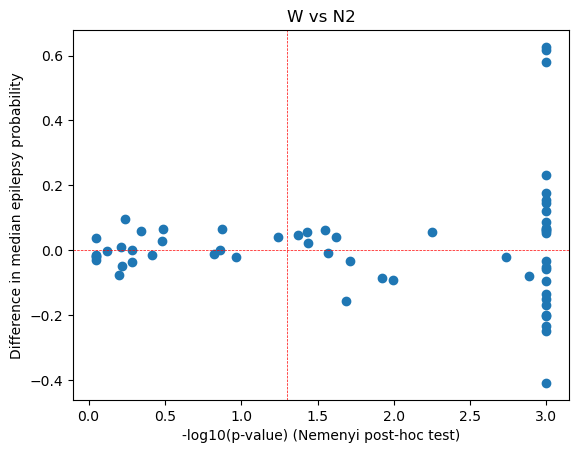

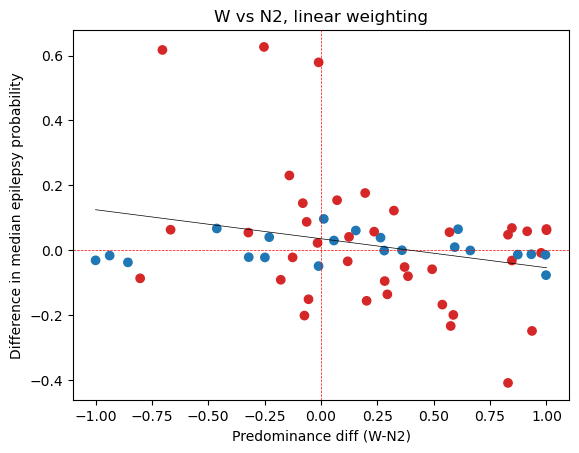

y = -0.08948742962915607x + 0.0353129631887397
r^2 = 0.07485149032883795
p-value = 0.03441475977352037


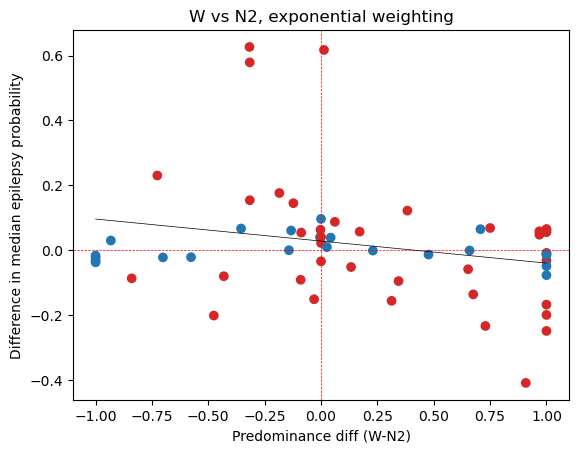

y = -0.06791922931512889x + 0.02806362319264294
r^2 = 0.061868872589947256
p-value = 0.05531457889888725


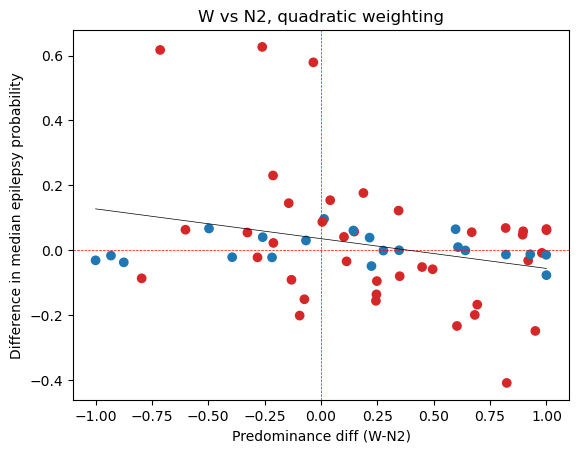

y = -0.09188745803809499x + 0.03553954904481868
r^2 = 0.08254654019885493
p-value = 0.026025582467930717
39/60 significant p-values.



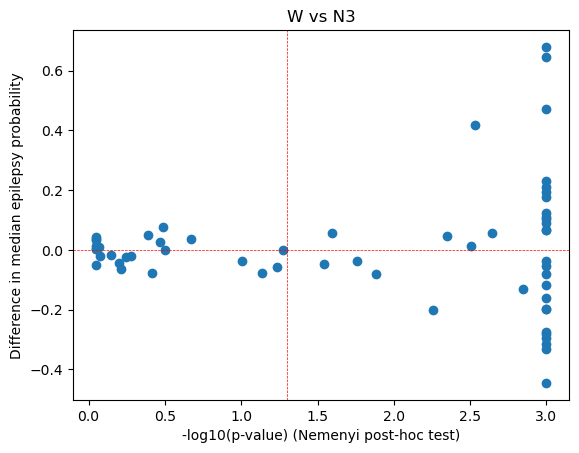

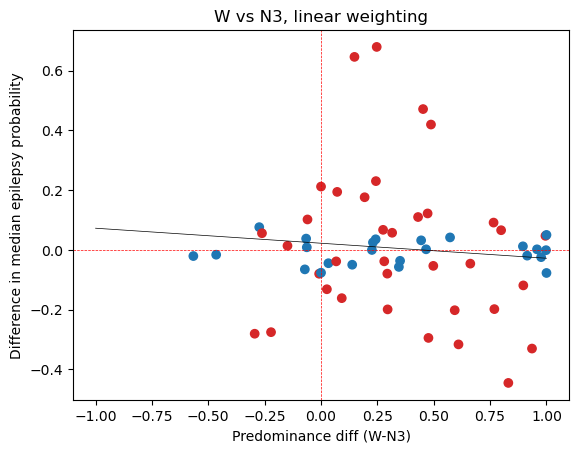

y = -0.05030725518639463x + 0.022222039769804643
r^2 = 0.010346946130606762
p-value = 0.4393131125819869


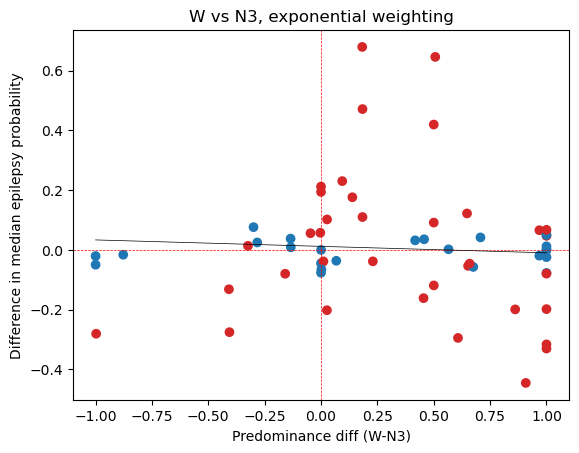

y = -0.021603045403037393x + 0.011730633680456494
r^2 = 0.0036585870499704675
p-value = 0.6461699902555988


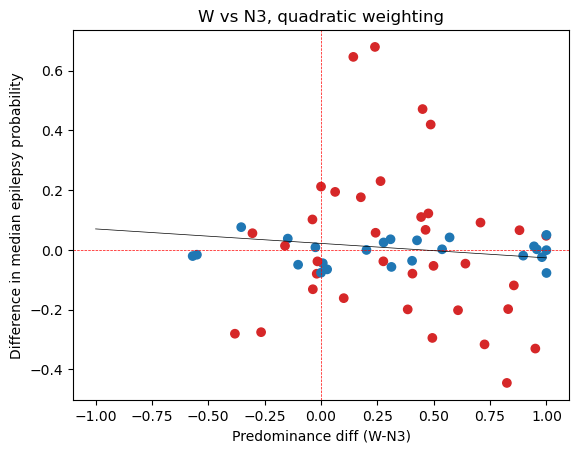

y = -0.04855413994513325x + 0.02161916072410297
r^2 = 0.010563619931404818
p-value = 0.4345368150643846
36/60 significant p-values.



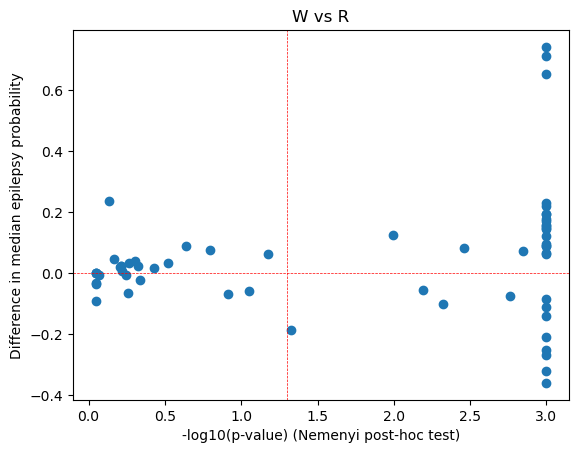

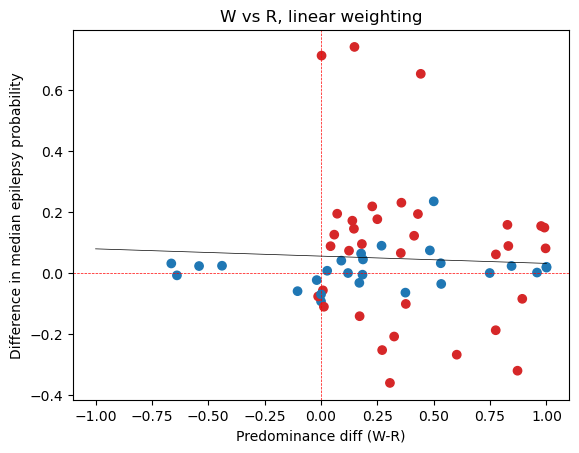

y = -0.023822560268032218x + 0.055373364701195964
r^2 = 0.002342648336879218
p-value = 0.7134395828121154


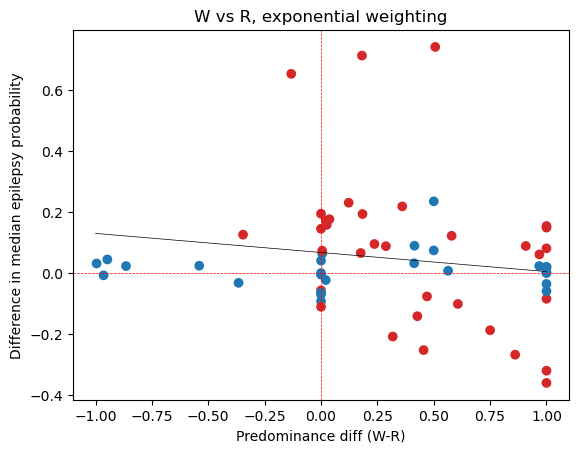

y = -0.06251571025143493x + 0.06726420546504497
r^2 = 0.029033313603263618
p-value = 0.19304435281080026


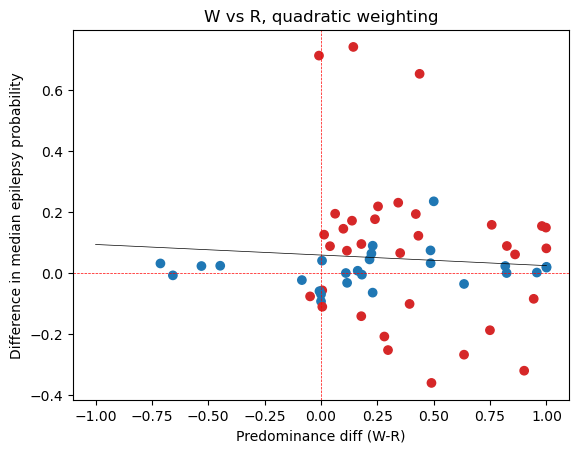

y = -0.0346515956449245x + 0.058874170724094906
r^2 = 0.005172776318353779
p-value = 0.5850011231279196
34/60 significant p-values.



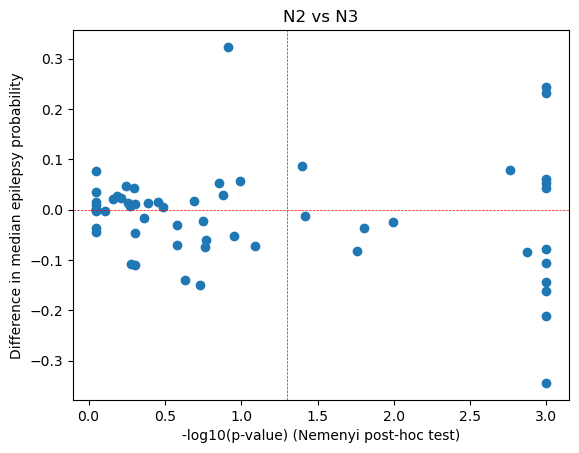

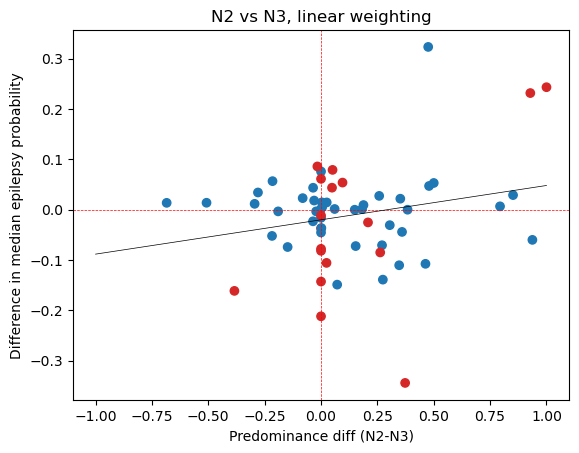

y = 0.06818615898449451x + -0.020030234721748016
r^2 = 0.05071029174249757
p-value = 0.08364588236388007


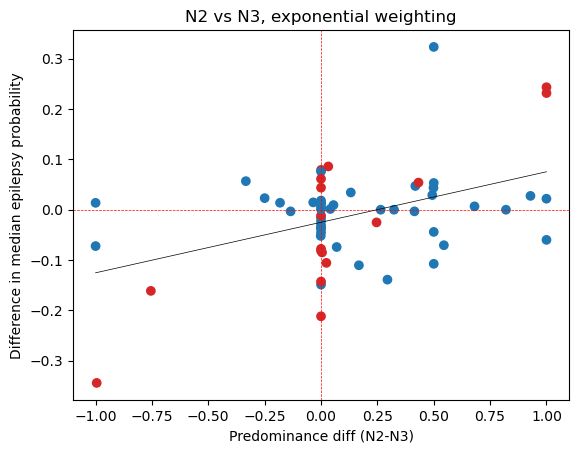

y = 0.1003807376805816x + -0.02495858676788424
r^2 = 0.1939913169793717
p-value = 0.00042866780974687603


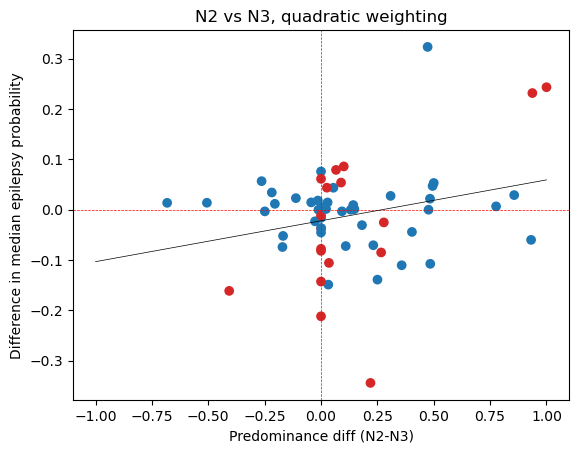

y = 0.08122620018252129x + -0.02195743998261393
r^2 = 0.07238794909811852
p-value = 0.03764379236104503
18/60 significant p-values.



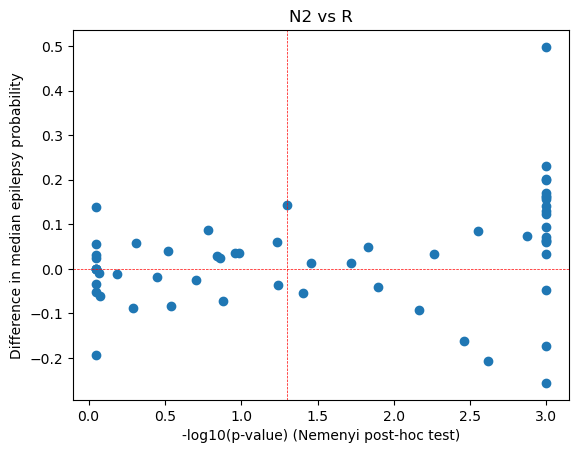

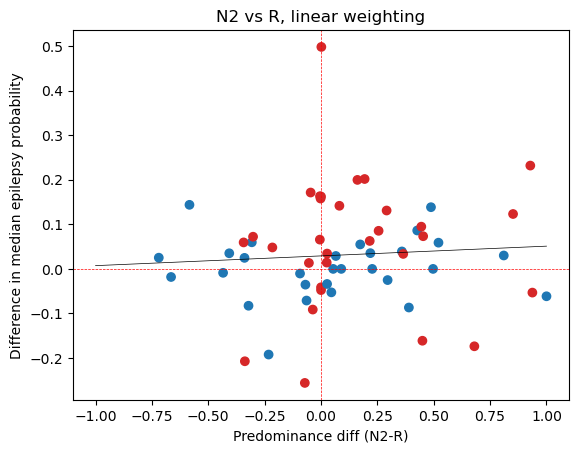

y = 0.021861398947575963x + 0.029172804998117165
r^2 = 0.00502171773945966
p-value = 0.5905486827520114


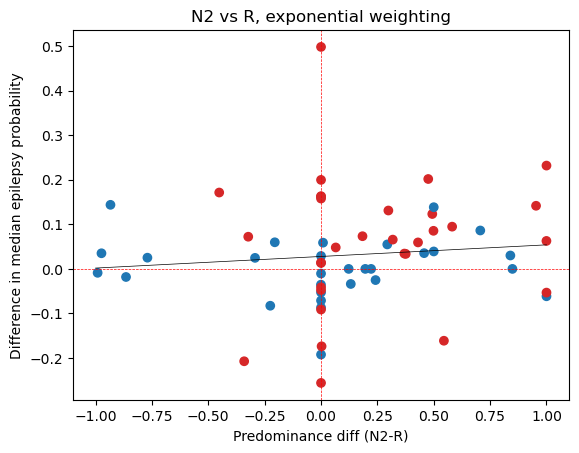

y = 0.026051591255923146x + 0.027903355928566787
r^2 = 0.010922446932162374
p-value = 0.4267966144900869


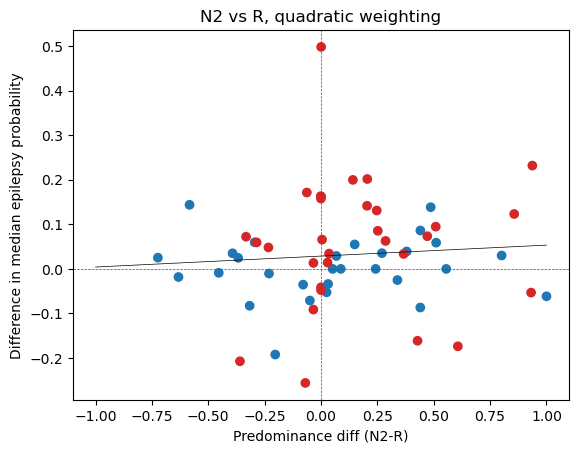

y = 0.024569611029283754x + 0.028779007884138747
r^2 = 0.006442898857357339
p-value = 0.5420893667302153
31/60 significant p-values.



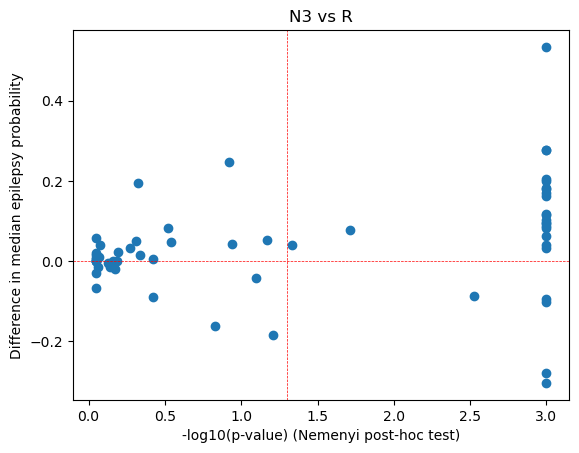

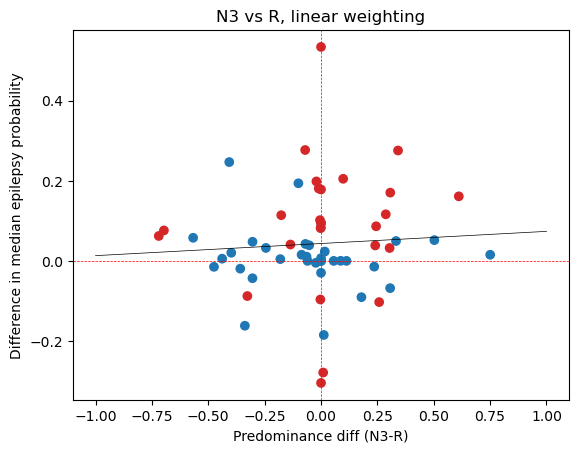

y = 0.03031831380314332x + 0.043418202095243844
r^2 = 0.004403301164079393
p-value = 0.6144403915757157


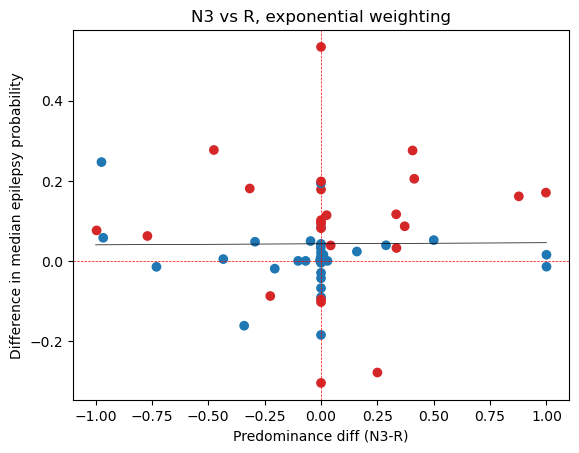

y = 0.002646340670859933x + 0.042735440356926356
r^2 = 6.73388860595679e-05
p-value = 0.9503816558998407


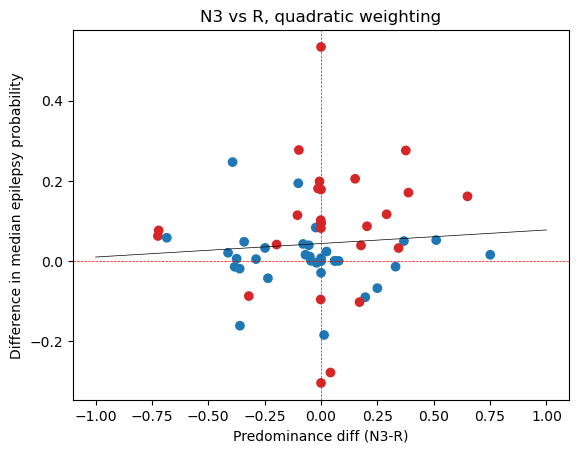

y = 0.03383153113065938x + 0.04345430185874197
r^2 = 0.005769095828365516
p-value = 0.5640749751085885
26/60 significant p-values.



In [23]:
def stage_predominance(stages, stage_to_assess, wts):
    all_preds = []
    for arr in stages:
        # count of entries in arr that equal stage_to_assess over total number of entries in arr
        stage_total = 0
        if wts == "linear":
            weights = [x/len(arr) for x in range(len(arr))]
        elif wts == "exponential":
            weights = [(math.e**x)/(math.e**len(arr)) for x in range(len(arr))]
        elif wts == "quadratic":
            weights = [(x**2)/(len(arr)**2) for x in range(len(arr))]
        else:
            print("Using linear weights.")
            weights = [x for x in range(len(arr))]
        #print(weights)
        for k in range(len(arr)):
            if num_to_stage_dict[arr[k]] == stage_to_assess:
                stage_total += weights[k]
        all_preds.append(stage_total/np.sum(weights))
    return np.mean(all_preds)

pair_order = [x for x in itertools.combinations(df_dist.columns,2)]
print(pair_order)

# calculate stage predominances

for plot_ind in range(len(pair_order)):
    pair = pair_order[plot_ind]
    all_p_vals = []
    effects_to_plot = []
    for k in range(len(all_nemenyi_res)):
        nem_res = all_nemenyi_res[k]
        p_val = nem_res[pair[0]][pair[1]]
        median_diff = all_median_diffs[k][plot_ind]
        all_p_vals.append(p_val)
        effects_to_plot.append(median_diff)
    # take -log10 of p-values
    all_p_vals_log = [-math.log10(x) for x in all_p_vals]

    # scatter plot
    plt.scatter(all_p_vals_log,effects_to_plot)
    plt.title(f"{pair[0]} vs {pair[1]}")
    plt.xlabel("-log10(p-value) (Nemenyi post-hoc test)")
    plt.ylabel("Difference in median epilepsy probability")
    # horizontal dotted line
    plt.axhline(0,color='red',linestyle='--',linewidth=0.5)
    # vertical dotted line
    plt.axvline(-math.log10(0.05),color='red',linestyle='--',linewidth=0.5)

    plt.show()

    for weight_type in ["linear","exponential","quadratic"]:
        
        all_pred_ratios = []
        predominances = pd.DataFrame({'W': [stage_predominance(all_stages_valid[i],'W',weight_type) for i in range(len(all_stages_valid))], 'N2': [stage_predominance(all_stages_valid[i],'N2',weight_type) for i in range(len(all_stages_valid))], 'N3': [stage_predominance(all_stages_valid[i],'N3',weight_type) for i in range(len(all_stages_valid))], 'R': [stage_predominance(all_stages_valid[i],'R',weight_type) for i in range(len(all_stages_valid))]})

        for k in range(len(all_nemenyi_res)):
            pred_ratio = predominances[pair[0]][k]-predominances[pair[1]][k]
            all_pred_ratios.append(pred_ratio)

        # scatter plot, color by all_p_vals, color blue if non-significant and red if significant
        plt.scatter(all_pred_ratios,effects_to_plot,c=['tab:blue' if x > 0.05 else 'tab:red' for x in all_p_vals])
        plt.title(f"{pair[0]} vs {pair[1]}, {weight_type} weighting")
        plt.xlabel(f"Predominance diff ({pair[0]}-{pair[1]})")
        plt.ylabel("Difference in median epilepsy probability")
        # horizontal dotted line
        plt.axhline(0,color='red',linestyle='--',linewidth=0.5)
        # vertical dotted line
        plt.axvline(0,color='red',linestyle='--',linewidth=0.5)
        # linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(all_pred_ratios,effects_to_plot)
        # plot line of best fit
        plt.plot(np.arange(-1,1.1,0.1),slope*np.arange(-1,1.1,0.1)+intercept,color='black',linestyle='-',linewidth=0.5)
        plt.show()

        # print equation, r^2, and p-value
        print(f"y = {slope}x + {intercept}")
        print(f"r^2 = {r_value**2}")
        print(f"p-value = {p_value}")

    # print number of significant p-values
    num_sig = len([x for x in all_p_vals_log if x > -math.log10(0.05)])
    print(f"{num_sig}/{len(all_p_vals_log)} significant p-values.\n")
    print("=====================================")
